## Filtering with SWE --- "immersed bump" example
*Connor Duffin*

In this notebok we are looking at DA for the shallow water equations using a linearised approximation to the SWE and using an extended Kalman filter (ExKF). In both cases, data is generated using the fully nonlinear SWE, with a variable topography. In this case there is no misspecification (aside from the use of the linearised equations underlying the filter).

In these scenarios we have a bump immersed in the terrain. We study the assimilation regime where approx $63$ points are observed at the observed timepoints. We observed every $4$ timesteps, giving a time between observations as $4 \Delta_t = 0.04$s.

First, we load in the appropriate libraries and get the sim set up:

In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
sys.path.insert(0, "../scripts")

from statfenics.utils import build_observation_operator
from swe import ShallowOne, ShallowOneLinear
from swe_filter import ShallowOneKalman, ShallowOneEx
from tqdm import tqdm

np.random.seed(27)

In [2]:
norm = np.linalg.norm

NX = 500
DT = 0.01
THETA = 0.6
NU = 1e-4

# set the observation system
t_final = 10.
nt = np.int64(t_final / DT)
t_grid = np.arange(0., t_final, DT)
print(t_grid.shape)

nt_skip = 4
nx_skip = 8
sigma_y = 5e-4

swe_dgp = ShallowOne(
    control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
    params=dict(nu=NU))

stat_params = dict(u_cov=dict(rho=1e-4, ell=5.),
                   h_cov=dict(rho=1., ell=5.),
                   k=32, k_init=32)

swe_post = ShallowOneKalman(
    control=dict(nx=NX, dt=DT, theta=THETA),
    params=dict(nu=0.),
    stat_params=stat_params,
    lr=True)

swe_post_ex = ShallowOneEx(
    control=dict(nx=NX, dt=DT, theta=THETA, simulation="immersed_bump"),
    params=dict(nu=NU),
    stat_params=stat_params,
    lr=True)

# build obs. operator
x_obs = swe_dgp.x_coords[::nx_skip]
nx_obs = len(x_obs)
nt_obs = len([i for i in range(nt) if i % nt_skip == 0])
H_obs = build_observation_operator(x_obs, swe_post.W, sub=1, out="scipy")

print(f"Assimilating every {nt_skip} timesteps ({nt_skip * swe_dgp.dt:.3f} s)")
print(f"Observational noise has std. dev. {sigma_y:.4e}")
print(f"Assimilating {H_obs.shape[0]} data points per time")

(1000,)
using PREVIOUS DERIVATIVE!!
Assimilating every 4 timesteps (0.040 s)
Observational noise has std. dev. 5.0000e-04
Assimilating 63 data points per time


To sanity check the sim we plot the leading eigenvalues for each of the filters: these should be the same for each of the filters. notice that there is lots of "headroom" for the filters in that the approximation is very accurate.

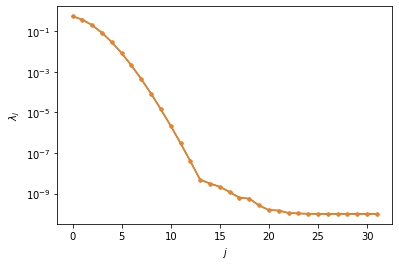

In [3]:
plt.semilogy(swe_post.G_vals, ".-")
plt.semilogy(swe_post_ex.G_vals, ".-")
plt.xlabel(r"$j$")
plt.ylabel(r"$\lambda_j$")
plt.show()

Next we run the simulation and, on the way, compute the errors in the mean(s):

In [4]:
def compute_errors(true, post):
    u_true, h_true = true.get_vertex_values()
    u_mean, h_mean = post.get_vertex_values()
    return (norm(u_true - u_mean) / norm(u_true), 
            norm(h_true - h_mean) / norm(h_true))

def compute_pp(H, swe_post): 
    mean_obs = H @ swe_post.mean 
    HL = H @ swe_post.cov_sqrt
    cov_obs = HL @ HL.T
    cov_obs[np.diag_indices_from(cov_obs)] += sigma_y**2 + 1e-10
    return mean_obs, cov_obs

errors_u = np.zeros((nt, ))
errors_h = np.zeros((nt, ))
errors_u_ex = np.zeros((nt, ))
errors_h_ex = np.zeros((nt, ))

y_obs = np.zeros((nt_obs, nx_obs))
means_obs = np.zeros((nt_obs, nx_obs))
covs_obs = np.zeros((nt_obs, nx_obs, nx_obs))

t = 0.
i_save = 0
for i in tqdm(range(nt)):
    t += swe_post.dt

    swe_dgp.solve(t)
    swe_post.prediction_step(t)
    swe_post_ex.prediction_step(t)
    
    if i % nt_skip == 0:
        y_obs[i_save, :] = swe_dgp.du.compute_vertex_values()[(NX + 1)::nx_skip]
        y_obs[i_save, :] += sigma_y * np.random.normal(size=(nx_obs, ))
        
        swe_post.update_step(y_obs[i_save, :], H_obs, sigma_y)
        swe_post_ex.update_step(y_obs[i_save, :], H_obs, sigma_y)
        means_obs[i_save, :], covs_obs[i_save, :, :] = compute_pp(H_obs, swe_post)
        i_save += 1
        
    swe_post.set_prev()
    swe_post_ex.set_prev()
    
    errors_u[i], errors_h[i] = compute_errors(swe_dgp, swe_post)
    errors_u_ex[i], errors_h_ex[i] = compute_errors(swe_dgp, swe_post_ex)

100%|█████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.56it/s]


And we first plot the filtered solutions alongside the true DGP, for the linear filter:

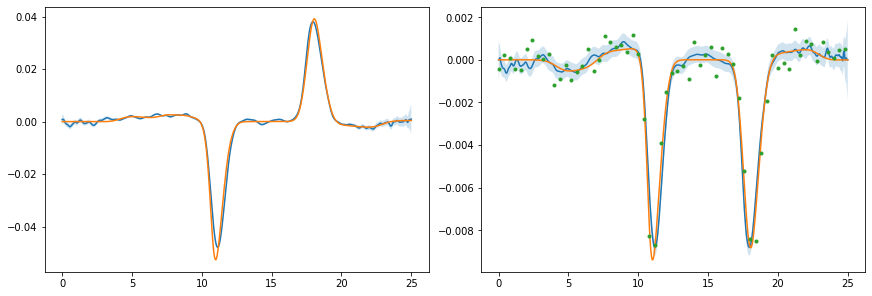

In [5]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
H_u_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=0)
H_h_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=1)

u_true, h_true = swe_dgp.get_vertex_values()
u_mean, h_mean = swe_post.get_vertex_values()
var_u = np.diagonal(H_u_verts @ swe_post.cov_sqrt @ (H_u_verts @ swe_post.cov_sqrt).T)
var_h = np.diagonal(H_h_verts @ swe_post.cov_sqrt @ (H_h_verts @ swe_post.cov_sqrt).T)

axs[0].plot(swe_dgp.x_coords, u_mean)
axs[0].fill_between(swe_dgp.x_coords[:, 0], 
                    u_mean - 1.96 * np.sqrt(var_u), u_mean + 1.96 * np.sqrt(var_u),
                    alpha=0.2)
axs[0].plot(swe_dgp.x_coords, u_true)

axs[1].plot(swe_dgp.x_coords, h_mean)
axs[1].fill_between(swe_dgp.x_coords[:, 0], 
                    h_mean - 1.96 * np.sqrt(var_h), h_mean + 1.96 * np.sqrt(var_h),
                    alpha=0.2)
axs[1].plot(swe_dgp.x_coords, h_true)
axs[1].plot(x_obs,  y_obs[-1, :], ".")
plt.show()

Next we plot the relative errors and we see that they look OK:

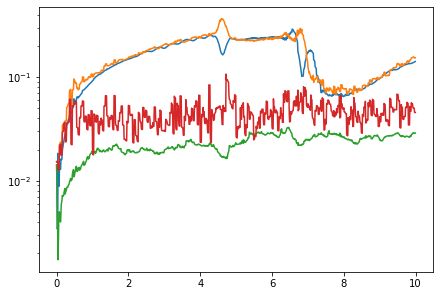

In [6]:
fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.semilogy(t_grid, errors_u)
ax.semilogy(t_grid, errors_h)
ax.semilogy(t_grid, errors_u_ex)
ax.semilogy(t_grid, errors_h_ex)
plt.show()

Next, we look at the prediction means and variances

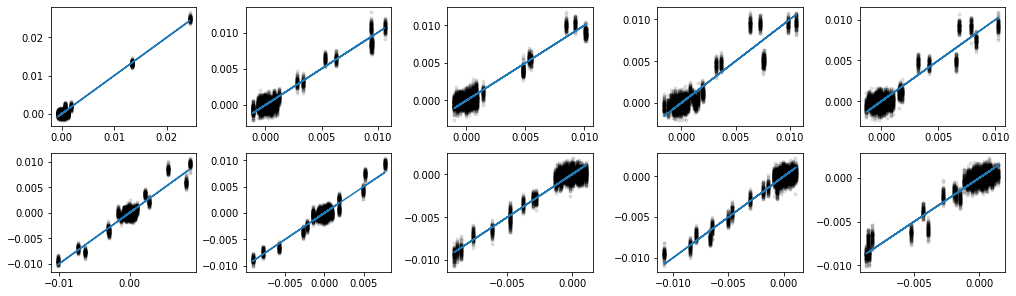

In [7]:
time_indices = np.int64(np.linspace(0, nt_obs - 1, 10))
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(14, 4))
axs = axs.flatten()
for i, idx in enumerate(time_indices):
    mean = means_obs[idx, :]
    cov = covs_obs[idx, :]
    y = y_obs[idx, :]
    samples = np.random.multivariate_normal(mean=mean, cov=cov, size=100)
    
    axs[i].plot(y, samples.T, ".", alpha=0.1, color="black")
    axs[i].plot(y, y)
    

In [8]:
coverage = np.zeros((nt_obs, ))
for i in range(nt_obs):
    mean = means_obs[i, :]
    cov = covs_obs[i, :]
    y = y_obs[i, :]
    lower = mean - 1.96 * np.sqrt(cov.diagonal())
    upper = mean + 1.96 * np.sqrt(cov.diagonal())
    coverage[i] = ((y > lower) & (y < upper)).sum() / nx_obs


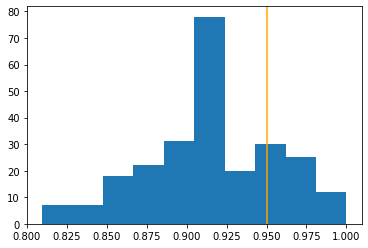

In [9]:
plt.hist(coverage, bins=10)
plt.axvline(x=0.95, color="orange")
plt.show()

In [10]:
for i in tqdm(range(int(5. / DT))):  # forecast forward 5s
    t += swe_post.dt
    swe_dgp.solve(t)
    
    swe_post_ex.prediction_step(t)
    swe_post_ex.set_prev()
    
    swe_post.prediction_step(t)
    swe_post.set_prev()


100%|███████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.92it/s]


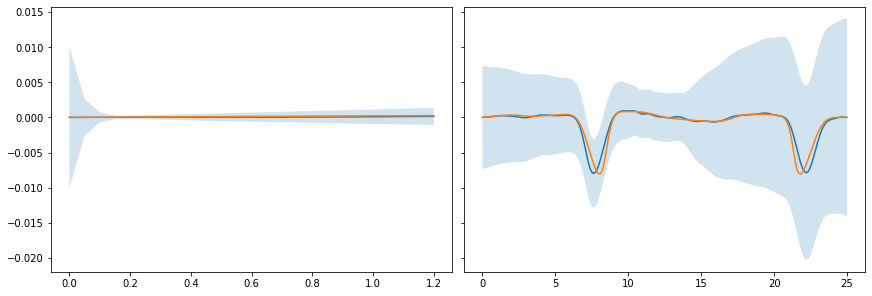

In [23]:
H_u_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=0)
H_h_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=1)

u_true, h_true = swe_dgp.get_vertex_values()
u_mean, h_mean = swe_post.get_vertex_values()
u_mean_ex, h_mean_ex = swe_post_ex.get_vertex_values()

var_u = np.diagonal(H_u_verts @ swe_post.cov_sqrt 
                    @ (H_u_verts @ swe_post.cov_sqrt).T)
var_h = np.diagonal(H_h_verts @ swe_post.cov_sqrt 
                    @ (H_h_verts @ swe_post.cov_sqrt).T)

var_u_ex = np.diagonal(H_u_verts @ swe_post_ex.cov_sqrt 
                       @ (H_u_verts @ swe_post_ex.cov_sqrt).T)
var_h_ex = np.diagonal(H_h_verts @ swe_post_ex.cov_sqrt 
                       @ (H_h_verts @ swe_post_ex.cov_sqrt).T)

subset_slice = 25
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4), sharey=True)
axs[0].plot(swe_dgp.x_coords[:subset_slice], h_mean_ex[:subset_slice])
axs[0].fill_between(swe_dgp.x_coords[:subset_slice, 0], 
                    h_mean_ex[:subset_slice] - 1.96 * np.sqrt(var_h_ex[:subset_slice]), h_mean_ex[:subset_slice] + 1.96 * np.sqrt(var_h_ex[:subset_slice]),
                    alpha=0.2)
axs[0].plot(swe_dgp.x_coords[:subset_slice], h_true[:subset_slice])

axs[1].plot(swe_dgp.x_coords, h_mean)
axs[1].fill_between(swe_dgp.x_coords[:, 0], 
                    h_mean - 1.96 * np.sqrt(var_h), h_mean + 1.96 * np.sqrt(var_h),
                    alpha=0.2)
axs[1].plot(swe_dgp.x_coords, h_true)
plt.show()